In [1]:
def find_nearest_index(array, value, nearest_value=False):
    """
    # Inputs
    Takes an array and a value as arguments.

    # Ouputs
    Return the index of the nearest value. Also returns (nearest_idx, nearest_value) if nearest_value is True.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if nearest_value :
        return idx, array[idx]
    return idx

def phi_pq (p,q,x,y, Lx, Ly) :  #Calcul analytique des déformées des modes d'une plaque en appuis simple
    """
    ## Inputs
    - p : numéro du mode selon x
    - q : numéro du mode selon y
    - x : arrayLike, vecteur des abscisses
    - y : arrayLike, vecteur des ordonnées

    ## Outputs
    - phi_pq : arrayLike, size (Nx,Ny), déformée du mode (p,q) en tous les points (x,y) du maillage
    """
    return np.sin(p*np.pi*x[:,np.newaxis]/Lx)*np.sin(q*np.pi*y[np.newaxis,:]/Ly)

def ravel_index_from_true_indexes(x_idx, y_idx, Nx) :
    return y_idx*Nx + x_idx

def plectre_Evangelista(L_plectre, S_plectre, rho_plectre, E,I,  v_g, f, T, rho_l, t):

    Z = np.sqrt(T*rho_l)                          # Impedance en N.s.m-1
    alpha =  (2*Z* (L_plectre**3))/(3*E*I)        # coefficient alpha 
    Prel = (4*Z*L_plectre*f)/(3 *alpha )           #force maximal avant release

    P_t = 2*Z*v_g*(1-np.exp(-t/alpha))            # force du plectre durant la phase d'accrochage
    
    
    # Calcul du point de release
    for j in range(len(P_t)):
        #print(P_t[j])
        if stick_t[j] >=Prel : 
            m = j
            break

    
    return m, P_t

def Force_ext(exc,Nx_C, x_C, L, t, L_plectre, S_plectre, rho_plectre, E,I,  v_g, f, T, rho_l, Fe):

    Fext = np.zeros_like(t) #force extérieur en fonction du temps
    xe_idx = find_nearest_index(x_C,(32.5+20)/65*L)
    Fextn_C = np.zeros((Nx_C,Nt))


    if exc =='plectre' : 
        m, P_t = plectre_Evangelista(L_plectre, S_plectre, rho_plectre, E,I,  v_g, f, T, rho_l, t)
        Fext[:m]=P_t[:m]
        Fextn_C[xe_idx -50:xe_idx +50, : ] = Fext
        return  Fext, Fextn_C

    else : 
        #Calcul du profil de force extérieure f_ext, cf Thèse Grégoire Dervaux : Force extérieure appliquée à la corde au point d'excitation xe
        temps_desc=1/2*1e-3
        fm = 0.187 # Force appliquée en N
        t1 = int(100e-3*Fe) #indice du temps où l'on lâche la corde
        t2 = t1 + int(temps_desc*Fe) #indice du temps où la force repasse à 0 (fin du glissement du plectre sur la corde) : à modéliser, int(1/2*1e-3*Fe) pour le moment #CF thèse Grégoire Derveaux, eq. 1.34
        Fext[:t1] = fm/2 * (1 - np.cos(np.pi*t[:t1]/t[t1]))
        Fext[t1:t2] = fm/2 * (1 + np.cos(np.pi*(t[t1:t2]-t[t1])/(t[t2]-t[t1])))
        Fextn_C[xe_idx, : ] = Fext
        return  Fext, Fextn_C


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from IPython.display import display, Audio
import scipy.integrate as intgr
import scipy.signal as sig
from numpy import linalg as LA
#Paramètres temporels 
Fe =int(44100*100)
h = 1/Fe
t_fin = 3 #durée simulation
t = np.linspace(0, t_fin, t_fin*Fe) #Vecteur temps
Nt = len(t)

In [5]:
# ÉTAPE 1 : DÉTERMINATION DES PARAMÈTRES DES SOUS-SYSTÈMES

#Paramètres de plectre :
E = 4.5e9                 #module d'Young du plectre 
rho_plectre = 1455        #masse volumique du plectre
L_plectre = 0.01          #longueur du plectre
S_plectre = 10-6          #section du plectre
I = 8.33e-14              #Moment d'inertie du plectre
v_g =  0.556              #Vitesse de la main en m.s-1, supposée constante
f = 0.025                 #coefficient de friction adimensionné

#======================================================== 1 CORDE ========================================================  

S = 1 #nombre de cordes


# Paramètres de la corde
L = 0.65
T =73.9 #tension de corde en N
rho_l = 3.61e-3 #masse linéique (kg.m)
ct = np.sqrt(T/rho_l) #vitesse des ondes (m.s-1)
B = 4e-5 #facteur d'inharmonicité
E = 4.5 #Module d'Young des cordes en NYLON
Section = 0.00097 # Diamètre en mm de la corde


Nx_C = 1000 #Discrétisation spatiale de la corde
x_C=np.linspace(0,L,Nx_C) #Vecteur de la corde

#Paramètres modaux de corde identiques
N_Y = 10  #Modes de cordes considérés
n_modes_Y = np.arange(1,N_Y+1) #ensemble des modes considérés pour la corde
#n_modes_Z = np.arange(1,N_Z+1) #ensemble des modes considérés pour la corde
mn_C = rho_l * L / 2  #Masses modales de la corde (kg)
pn_C = (2 * n_modes_Y - 1) * np.pi / (2 * L)
fn_C = (ct / (2 * np.pi)) * pn_C * (1 + pn_C**2 * B / (2 * T)) #Fréquences propres de corde (Hz)
wn_C = 2*np.pi*fn_C #pulsation propre (N.m)

#Amortissement
etaf, etaA, etaB = 7e-5, 0.9, 2.5e-2 
xin_C = 1/2 * ( (T*(etaf + (etaA/(2*np.pi*fn_C)))) + (etaB*B*(pn_C**2)) ) / (T + (B*(pn_C**2))) #Amortissements modaux de la corde (ø)

#Déformée modale de corde fixe-fixe
phin_Y = np.sin((2*n_modes_Y[np.newaxis,:]-1)*np.pi*x_C[:,np.newaxis] / (2 * L)) #Déformées d'une corde fixe aux extrémités


### Matrices modales suivant Y
M_y = np.ones(N_Y)*mn_C #matrice d'inertie de la corde, non diagonale et identique pour tous les modes (cas seulement de la corde)
M_y_inv = np.ones(N_Y)*1/mn_C #matrice d'inertie inverse de la corde
C_y = mn_C * np.ones(N_Y)*2*wn_C*xin_C #matrice d'amortissement de la corde
K_y = mn_C*np.ones(N_Y)*wn_C**2 #matrice de raideur de la corde


# Diagonalisation
M_Y, M_Y_inv, C_Y, K_Y = np.diag(M_y), np.diag(M_y_inv), np.diag(C_y), np.diag(K_y)

In [6]:
#======================================================== MODELE DE DOIGT======================================================== 

#paramètre d'un seul système masse-ressort, idem suivant Y et Z
mf =  0.001
mf_inv = 1/mf
cf = 1
kf = 10e5

F = 1 #nombre de ressorts du doigt sur les cordes, cas simple avec un seule ressort où taille Af = Ab et F = S = 1 
x_Ff = find_nearest_index(x_C,0.5*L) #position des ressorts


M_f = mf* np.ones(F) #masses des deux ressorts, l'un suivant Y l'autre suivant Z
M_f_inv = np.ones(F)*1/mf #matrice inverse
K_f = kf* np.ones(F) #matrice de raideur
C_f = cf* np.ones(F)

# Forces extérieurs au doigt
Fextn_F = np.zeros((F, len(t))) #pas de force extérieure sur le corps 

# Diagonalisation
M_F, M_F_inv, C_F, K_F = np.diag(M_f), np.diag(M_f_inv), np.diag(C_f), np.diag(K_f)


v = 2
Fext = np.zeros((N_Y+F, len(t)))
Fext[N_Y:,:]= -kf*v*t
deltac = 0.001

In [7]:
#======================================================== SYSTÈME COMPLET ======================================================== 


M = np.concatenate((M_y, M_f))  #matrice d'inertie, taille S*N_Y + S*N_Z + N_B + S*F 
M_inv = np.concatenate((M_y_inv,  M_f_inv)) #matrice d'inertie inverse
K = np.concatenate((K_y,K_f))  #matrice de raideur
C = np.concatenate((C_y,  C_f))  #matrice d'amortissement


#Diagonalisation
M = np.diag(M) #matrice des masses de taille len(M)*len(M)
M_inv = np.diag(M_inv)
C = np.diag(C)
K = np.diag(K)

#========================================================
#Déforméex aux points de couplage 

phi_YsF = phin_Y[x_Ff,:] #Déformée de la corde au point de couplage avec le doigt, soit en x_F, taille N_Y * F (F poisition x_Ff)
#phi_YsB = phin_Y[-1,:] #déformée de la corde au point du chevalet, soit le dernier point (indice -1)


#========================================================
# Matrices de contraintes dûes aux contraintes aux points corde/chevalet et corde/doigt/fret
#Couplage au niveau du doigt

t_release = find_nearest_index(t,0.1)

#Couplage au niveau du doigt
A = np.block([
    [phi_YsF , -np.ones(F)], #ligne de taille F*N_Y + F*N_Z + N_B + F + F

])


b =np.zeros(N_Y+F)

B = A @ np.sqrt(M_inv)
Bplus = B.T @ np.linalg.inv((B @ B.T))
Z = - np.sqrt(M) @ Bplus @ A #pour calculer la force ensuite
W = np.eye(N_Y+ F ) - np.sqrt(M_inv) @ Bplus @ A


schéma instable !


KeyboardInterrupt: 

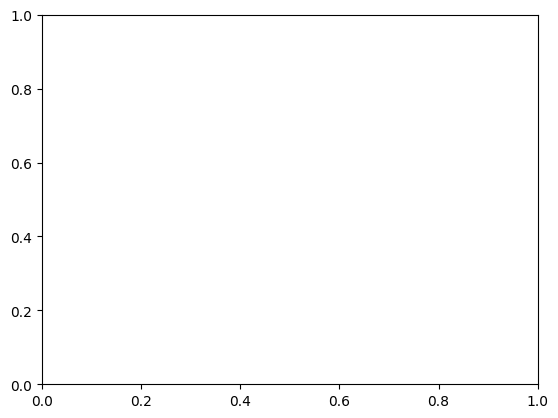

In [8]:
h =(1/(Fe))


Q=np.zeros((N_Y+F, len(t)))

for i in range(len(t)-1):

  if h > 2/np.max(LA.eig(W*M_inv*K)[0]):
    print("schéma instable !")
    break
  else : 
    print("conditions de stabilité respectées !")
  if t[i]<0.1 : 

    a = np.sqrt(M_inv)*Bplus@b
    c = M_inv*np.sqrt(M_inv)*Bplus*A*M_inv

    Q[:,i+1] = 2*Q[:,i+1] -Q[:,i-1] + h**2*a - h*c*C@(Q[:,i] -Q[:,i-1]) - h**2*c*K@Q[:,i] + h**2*c@Fext[:,i]
  
  else : 
    Q[:,i+1] = 2*Q[:,i] -Q[:,i-1] -h*C@(Q[:,i] -Q[:,i-1]) - h**2*K@Q[:,i] +  h**2*Fext[:,i] 
  

X_C = phi_YsF @ Q[:N_Y, :]

plt.plot(t,X_C)
display(Audio(X_C,rate=Fe)) # Listening all song

In [118]:
# Méthode ODE  
from numpy import diff

len_q = N_Y+F

def derive_Q(temps,Q): #Fonction dérivée
    print(temps)
    indice = find_nearest_index(t,temps)
    Qprim = np.zeros(2*len_q)
    Qprim[:len_q] = Q[len_q:2*len_q] #dq = dq

    if temps<0.1 : #Si on est en phase d'accrochage
        Qprim[len_q:2*len_q] = W@ M_inv@(-C@Q[len_q:2*len_q] - K@Q[:len_q] + Fext[:,indice])
        print(np.max(Qprim[:len_q] ))
    else : #phase de lâché, plus de contraintes
        Qprim[len_q:2*len_q] =  M_inv@(-C@Q[len_q:2*len_q] - K@Q[:len_q] + Fext[:,indice])
        print(np.max(Qprim[:len_q] ))
    return Qprim

X0 = np.zeros(2*len_q)
sol = intgr.solve_ivp(fun = derive_Q, t_span = (0,t_fin), y0 = X0, t_eval = t, dense_output= False, method = 'RK45')
    

0.0
0.0
1e-06
0.0
2e-07
0.0
3e-07
0.0
8e-07
0.0
8.888888888888888e-07
0.0
1e-06
0.0
1e-06
0.0
3e-06
0.0
4e-06
0.0
9e-06
0.0
9.888888888888889e-06
0.0
1.1e-05
0.0
1.1e-05
0.0
3.0999999999999995e-05
0.0
4.0999999999999994e-05
0.11810201371063321
9.099999999999999e-05
1.7389508199292356
9.988888888888888e-05
4.568248306312228
0.00011099999999999999
4.20174678490419
0.00011099999999999999
0.6730926009567957
1.79356604369349e-05
0.0
2.1403490655402346e-05
0.04095577320075909
3.87426417477396e-05
0.25517271954371284
4.182515749748844e-05
2.791456302118844
4.567830218467449e-05
1.9418926726465198
4.567830218467449e-05
0.22443682005275264
1.5696632190667674e-05
0.0
1.8044948286001513e-05
0.027734085968801753
2.97865287626707e-05
0.16653298162050195
3.1873920847411884e-05
1.727870112529867
3.448316095333837e-05
1.4803979160824212
3.448316095333837e-05
0.12066502111327983
1.3765321530874897e-05
0.0
1.5147982296312346e-05
0.01632950206768482
2.206128612349959e-05
0.09487200348167321
2.32903179149

KeyboardInterrupt: 

In [ ]:
print(sol)

X_C = phi_YsF @ sol[['y']:N_Y, :]

plt.plot(t,X_C)

display(Audio(X_C,rate=Fe)) # Listening all song

In [84]:
#Initialisation 
q = np.zeros((N_Y+F, len(t)))
dq = np.zeros((N_Y+F, len(t)))
ddq = np.zeros((N_Y+F, len(t)))

#Variables des boucles 
qu = np.zeros((N_Y+F, len(t)))
dqu = np.zeros((N_Y+F, len(t)))
ddqu = np.zeros((N_Y+F, len(t)))

dq_demi = np.zeros(N_Y+F)
h =(1/Fe)

for i in range(len(t)-1):

    if t[i]>= 1 : 
        print('oui')

    B = A[:,:,i] @ np.sqrt(M_inv)
    Bplus = B.T @ np.linalg.inv((B @ B.T))
    Z = - np.sqrt(M) @ Bplus @ A[:,:,i]#pour calculer la force ensuite
    W = np.eye(N_Y+ F ) - np.sqrt(M_inv) @ Bplus @ A[:,:,i]

        
    #1.
    q[:, i+1] = q[:, i]  + (h*dq[:, i]) + 0.5*h**2*ddq[:, i+1]
    dq_demi= dq[:, i] + 0.5*h*ddq[:, i]

    #2. 

    F_ = Fext[:,i+1] -C@dq_demi  - K@q[:, i+1] 


    #3. 
    ddqu[:,i+1] = M_inv@ F_

    #4. 
    ddq[:,i+1] = W @ ddqu[:,i+1]
        
    #5. 
    dq[:, i+1] = dq[:, i] + 0.5*h*(ddq[:,i]+ddq[:,i+1])


LinAlgError: Singular matrix

In [ ]:
# Méthode ODE  
#from numpy import diff
#def derive_Q(temps,Q): #Fonction dérivée
    #indice = find_nearest_index(t,temps)

    #print(temps)
    #Fnl = np.zeros((Lenght_q))
    #Fnl[:N_Y] = - (E*Section*np.pi**4 / 128* L**3 ) * (2*n_modes_Y[np.newaxis,:]-1)**2 * Q[:N_Y] * (((2*n_modes_Y[np.newaxis,:]-1)**2@(Q[:N_Y]**2))+((2*n_modes_Z[np.newaxis,:]-1)**2@(Q[N_Y:N_Y+N_Z]**2)))
    #Fnl[N_Y:N_Y+N_Z] = - (E*Section*np.pi**4 / 128* L**3 ) * (2*n_modes_Y[np.newaxis,:]-1)**2 * Q[N_Y:N_Y+N_Z] * (((2*n_modes_Y[np.newaxis,:]-1)**2 @ (Q[:N_Y]**2))+((2*n_modes_Z[np.newaxis,:]-1)**2 @ (Q[N_Y:N_Y+N_Z]**2)))

    #Qprim = np.zeros(3*Lenght_q)
    #Qprim[:Lenght_q] = Q[Lenght_q:2*Lenght_q]
    #Qprim[Lenght_q:2*Lenght_q] = M_inv@(-C@Q[2*Lenght_q:3*Lenght_q] - K@Q[Lenght_q:2*Lenght_q] + Fext[:Lenght_q,indice] - Fnl)
    #Qprim[2*Lenght_q: 3*Lenght_q] = W@ (M_inv@(-C@Q[2*Lenght_q:3*Lenght_q] - K@Q[Lenght_q:2*Lenght_q] +Fext[:Lenght_q,indice] - Fnl))

    #return Qprim

#X0 = np.zeros(3*Lenght_q)
#sol = intgr.solve_ivp(fun = derive_Q, t_span = (0,t_fin), y0 = X0, t_eval = t, dense_output= False, method = 'RK45')
    

0.0
1e-06
2e-07
3e-07
8e-07
8.888888888888888e-07
1e-06
1e-06
3e-06
4e-06
9e-06
9.888888888888889e-06
1.1e-05
1.1e-05
3.0999999999999995e-05
4.0999999999999994e-05
9.099999999999999e-05
9.988888888888888e-05
0.00011099999999999999
0.00011099999999999999
1.4999999999999999e-05
1.7e-05
2.6999999999999996e-05
2.8777777777777773e-05
3.0999999999999995e-05
3.0999999999999995e-05
3.5e-05
3.699999999999999e-05
4.699999999999999e-05
4.877777777777777e-05
5.099999999999999e-05
5.099999999999999e-05
5.571555939300198e-05
5.807333908950298e-05
6.986223757200795e-05
7.195804174667551e-05
7.457779696500995e-05
7.457779696500995e-05
5.194311187860039e-05
5.241466781790059e-05
5.4772447514401584e-05
5.5191608349335094e-05
5.571555939300198e-05
5.571555939300198e-05
5.118862237572007e-05
5.1282933563580114e-05
5.1754489502880314e-05
5.183832166986701e-05
5.194311187860039e-05
5.194311187860039e-05
5.1037724475144006e-05
5.1056586712716016e-05
5.115089790057606e-05
5.11676643339734e-05
5.11886223757200

KeyboardInterrupt: 